In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras

In [3]:
keras.utils.set_random_seed(812)

In [4]:
path = 'C:\\Users\\heide\\Documents\\HSLU\\Data_axial\\Training'

In [5]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [6]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    labels = 'inferred',
    label_mode = 'int',
    validation_split=0.2,
    subset="training",
    seed = 123,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE) 
    #crop_to_aspect_ratio = TRUE

Found 1078 files belonging to 4 classes.
Using 863 files for training.


In [7]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    path,
    labels = 'inferred',
    label_mode = 'int',
    validation_split=0.2,
    subset="validation",
    seed=123,
    batch_size = BATCH_SIZE,
    image_size = IMG_SIZE)

Found 1078 files belonging to 4 classes.
Using 215 files for validation.


In [8]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_ds.prefetch(buffer_size=AUTOTUNE)
validation_dataset = val_ds.prefetch(buffer_size=AUTOTUNE)

In [9]:
preprocess_input = tf.keras.applications.vgg19.preprocess_input

In [10]:
IMG_SHAPE = IMG_SIZE + (3,)

In [11]:
base_model = tf.keras.applications.VGG19(include_top=False,
                                         weights="imagenet",
                                         input_shape=IMG_SHAPE)

80134624/80134624 [==============================] - 4s 0us/step


In [12]:
base_model.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 160, 160, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 160, 160, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 80, 80, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 80, 80, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 80, 80, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 40, 40, 128)       0     

In [13]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 512)


In [14]:
base_model.trainable = False

In [15]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 512)


In [16]:
prediction_layer = tf.keras.layers.Dense(1)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 1)


In [17]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = preprocess_input(inputs)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [18]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0, name='accuracy')])

In [19]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(validation_dataset)

7/7 [==============================] - 17s 2s/step - loss: -2.6071 - accuracy: 0.3349


In [20]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: -2.61
initial accuracy: 0.33


In [21]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10
27/27 [==============================] - 86s 3s/step - loss: -4.0585 - accuracy: 0.2584 - val_loss: -3.7333 - val_accuracy: 0.3256
Epoch 2/10
27/27 [==============================] - 86s 3s/step - loss: -5.2383 - accuracy: 0.2619 - val_loss: -4.7942 - val_accuracy: 0.3256
Epoch 3/10
27/27 [==============================] - 87s 3s/step - loss: -6.6301 - accuracy: 0.2584 - val_loss: -5.8405 - val_accuracy: 0.3256
Epoch 4/10
27/27 [==============================] - 90s 3s/step - loss: -7.8636 - accuracy: 0.2572 - val_loss: -6.8802 - val_accuracy: 0.3256
Epoch 5/10
27/27 [==============================] - 88s 3s/step - loss: -9.2051 - accuracy: 0.2584 - val_loss: -7.9361 - val_accuracy: 0.3256
Epoch 6/10
27/27 [==============================] - 89s 3s/step - loss: -10.4578 - accuracy: 0.2584 - val_loss: -8.9403 - val_accuracy: 0.3256
Epoch 7/10
27/27 [==============================] - 88s 3s/step - loss: -11.5523 - accuracy: 0.2584 - val_loss: -9.9847 - val_accuracy: 0.3256
Epoc

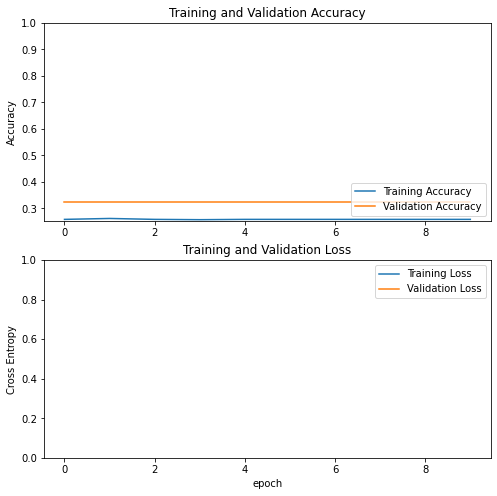

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()